In [1]:
import sys
import os
import numpy as np
root_path = 'C://Users//HP//projects//DiplomaThesis'
sys.path.append(f'{root_path}')

from figures import Results, style_plot_df, corrplot, plot_df_simple
from backtest import get_returns

%load_ext autoreload 
%autoreload 2
%matplotlib inline

In [14]:
from empyrical import max_drawdown, sharpe_ratio
from empyrical.stats import cum_returns, aggregate_returns

# Backtest

In [ ]:
def get_metrics(path_to_models, percent_long=10, percent_short=)

In [5]:
r = get_returns(hidden_layers="32,16,8,4,2", percent_short=10, percent_long=10)

In [13]:
aggregate_returns(r["Long-short"], convert_to="yearly").mean()

0.2768489326025242

In [17]:
sharpe_ratio(r["Long-short"],period='monthly')

2.4939449048219315

In [7]:
max_drawdown(r["Long-short"])

-0.10311223788700162

<AxesSubplot:xlabel='date'>

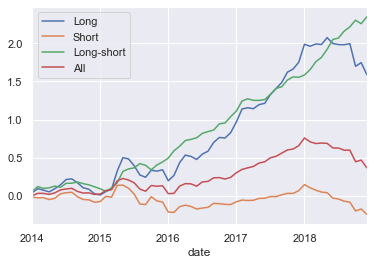

In [10]:
cum_returns(r).plot()

# Ensembles

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
C:\Users\HP\projects\DiplomaThesis\figures.py:236: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
C:\Users\HP\projects\DiplomaThesis\figures.py:236: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: Matplot

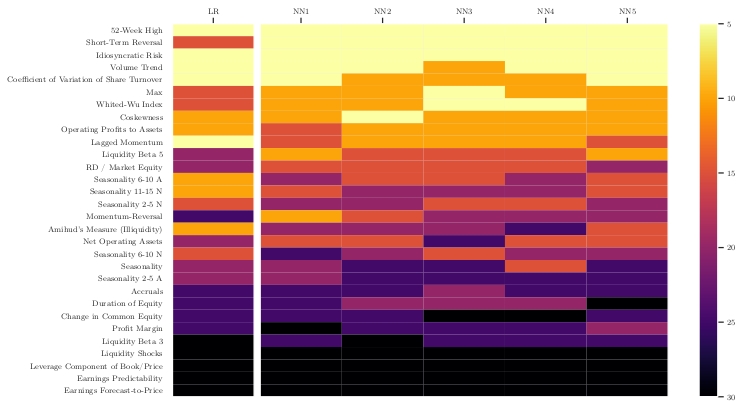

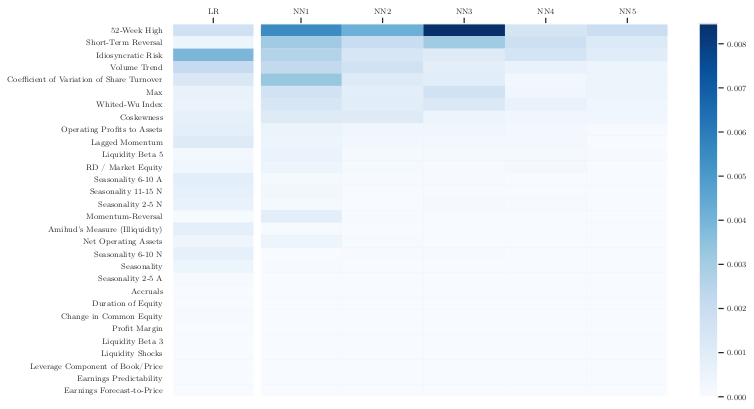

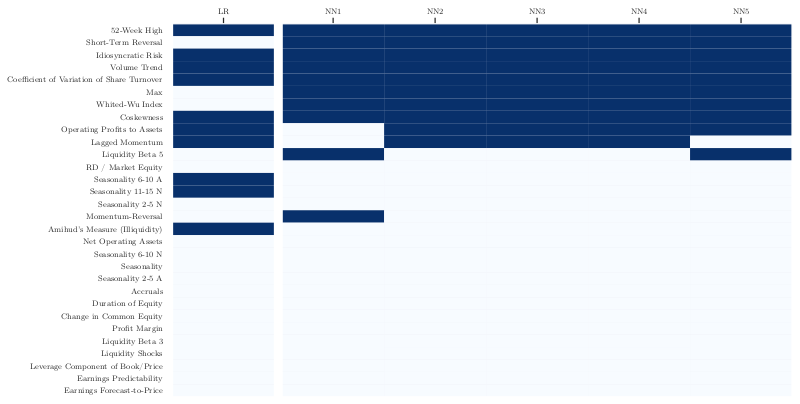

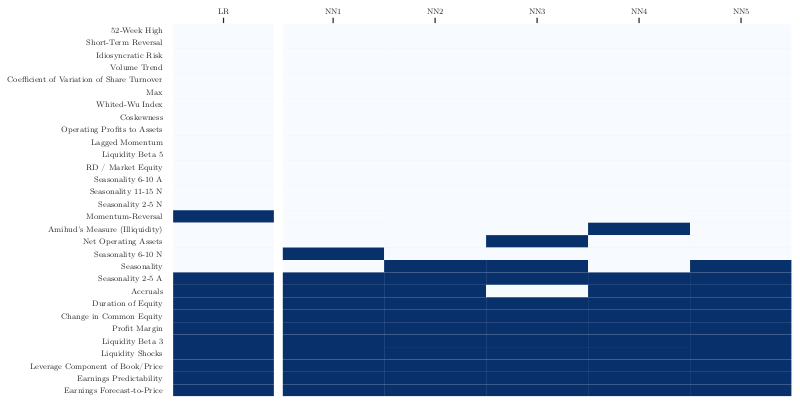

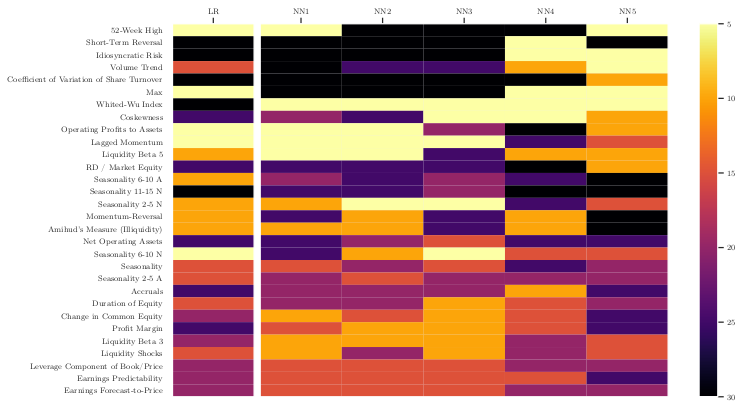

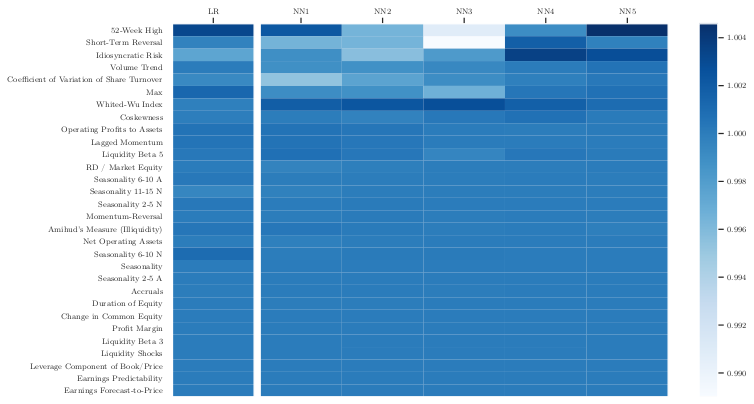

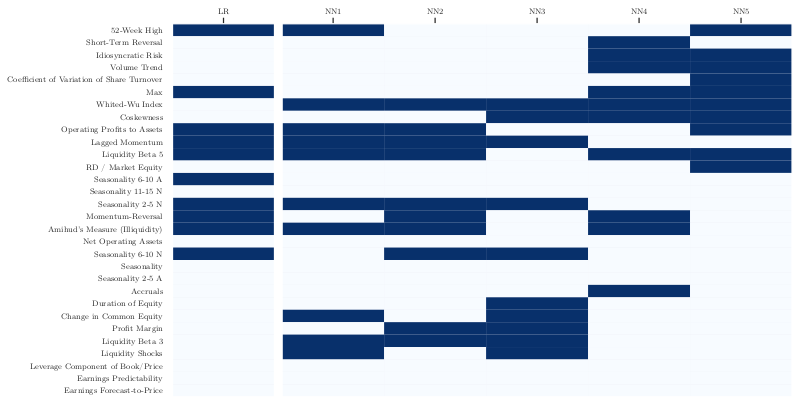

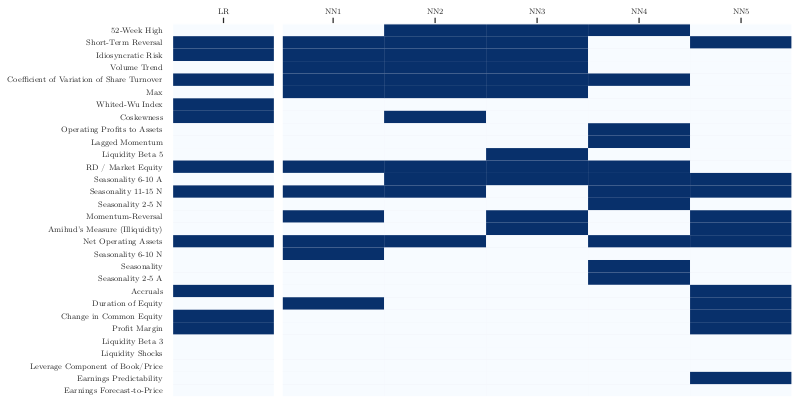

In [150]:
r = Results(os.path.join("results", "selected", "ensembles"))
r.load()
r.subset('ytrain',16)
r.rename(['nn_name'])

for styling in ["heatmap", "blues", "top", "bottom"]: 
    style_plot_df(r.ig.transpose(), styling=styling, mode='ensemble')

for styling in ["heatmap", "blues", "top", "bottom"]: 
    style_plot_df(r.mr.transpose(), styling=styling, mode='ensemble')

# Robustness of ensembles in time

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
C:\Users\HP\projects\DiplomaThesis\figures.py:236: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
C:\Users\HP\projects\DiplomaThesis\figures.py:236: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


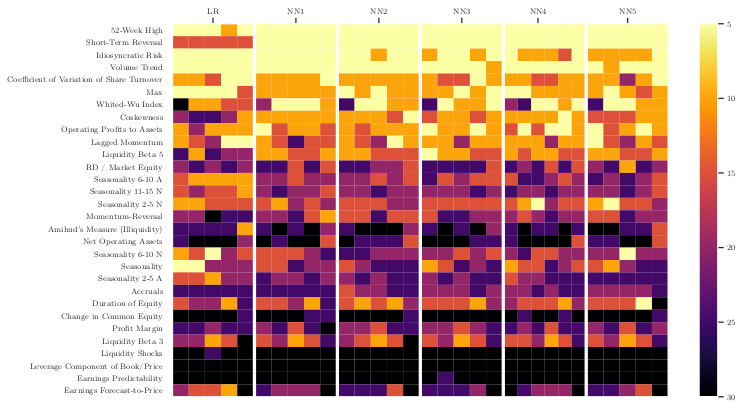

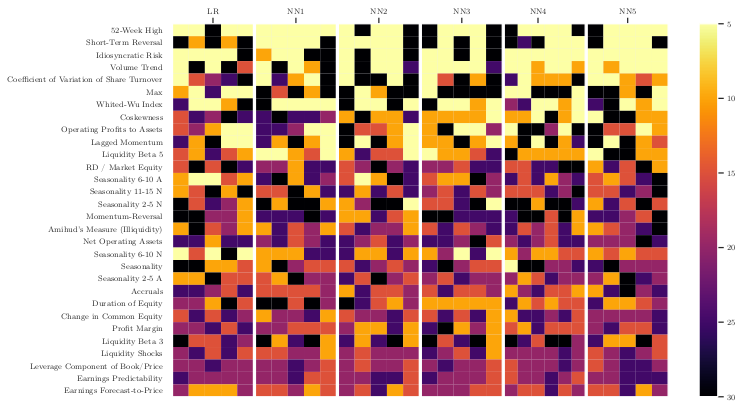

In [151]:
r = Results(os.path.join("results", "selected", "ensembles"))
r.load()
r.rename(['nn_name', "ytrain"])

for styling in ["heatmap"]: 
    style_plot_df(r.ig.transpose(), styling=styling, mode='ensemble_time')

for styling in ["heatmap"]: 
    style_plot_df(r.mr.transpose(), styling=styling, mode='ensemble_time')

# Seeds

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
C:\Users\HP\projects\DiplomaThesis\figures.py:236: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
C:\Users\HP\projects\DiplomaThesis\figures.py:236: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


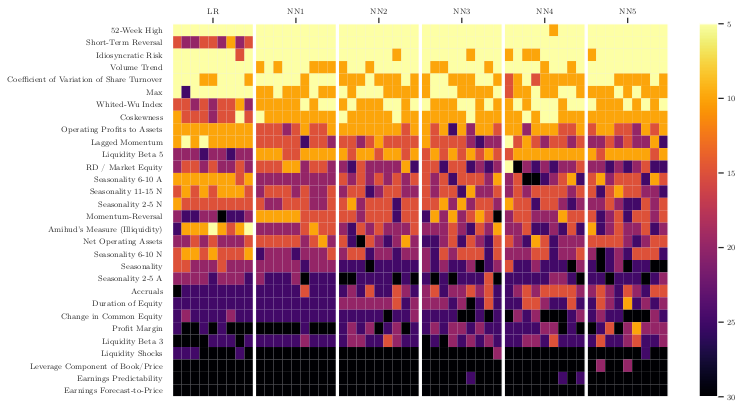

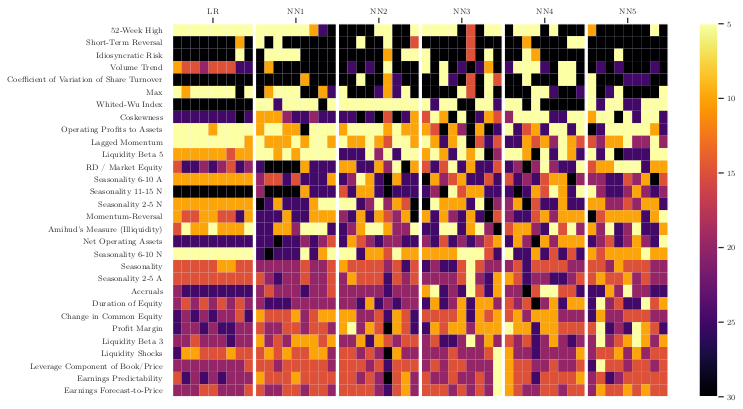

In [153]:
r = Results(os.path.join("results", "selected", "individual"))
r.load()
r.subset('ytrain',16)
r.rename(['nn_name', "seed"])

for styling in ["heatmap"]: 
    style_plot_df(r.ig.transpose(), styling=styling, mode='seeds')

for styling in ["heatmap"]: 
    style_plot_df(r.mr.transpose(), styling=styling, mode='seeds')

# Ensembles - simulations

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
C:\Users\HP\projects\DiplomaThesis\figures.py:236: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


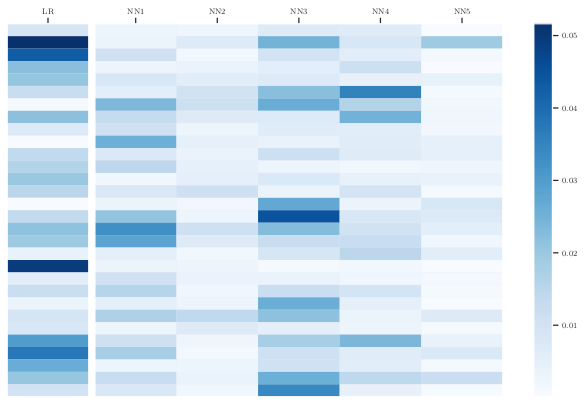

In [180]:
r = Results(os.path.join("results", "simulated", "ensembles"))
r.load(sort_features=False)
r.subset('ytrain',16)
r.rename(['nn_name'])

for styling in ["blues"]: 
    style_plot_df(r.ig.transpose(), styling=styling, mode='ensemble')

# Seeds - simulations

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
C:\Users\HP\projects\DiplomaThesis\figures.py:236: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


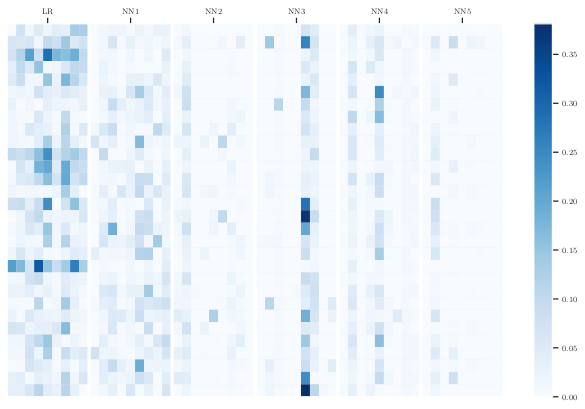

In [168]:
r = Results(os.path.join("results", "simulated", "individual"))
r.load(sort_features=False, suffix="_train")
r.subset('ytrain',16)
r.rename(['nn_name', "seed"])

for styling in ["blues"]: 
    style_plot_df(r.ig.transpose(), styling=styling, mode='seeds')

In [160]:
r.ig.transpose()

,LR-1,NN1-1,NN2-1,NN3-1,NN4-1,LR-2,NN1-2,NN2-2,NN3-2,NN1-3,...,NN4-8,NN5-2,NN4-9,NN5-3,NN5-4,NN5-5,NN5-6,NN5-7,NN5-8,NN5-9
C1,0.002395,0.000653,0.004382,0.001618,0.000095,0.075416,0.013364,0.014295,0.001003,0.016175,...,0.009510,0.000139,0.004487,0.002542,0.000882,8.811418e-06,0.000271,0.001052,0.0,7.080385e-06
C2,0.063953,0.000203,0.009039,0.002921,0.001404,0.058542,0.018052,0.045209,0.143231,0.063179,...,0.001967,0.042979,0.009908,0.001484,0.092611,1.046426e-04,0.020994,0.016206,0.0,5.048379e-04
C3,0.072433,0.000503,0.001017,0.002165,0.000014,0.120071,0.010813,0.018690,0.000965,0.016677,...,0.009335,0.011223,0.004993,0.001860,0.000467,1.597722e-06,0.000208,0.000512,0.0,2.072239e-05
C4,0.035687,0.000677,0.000150,0.001002,0.000072,0.097994,0.021972,0.029982,0.001296,0.012710,...,0.009685,0.000073,0.006482,0.002358,0.000089,9.905383e-07,0.001714,0.001188,0.0,2.932691e-05
C5,0.046765,0.000243,0.005352,0.001747,0.000192,0.087478,0.017403,0.056736,0.000101,0.005009,...,0.009063,0.014628,0.001016,0.000996,0.050385,2.114529e-06,0.001040,0.002090,0.0,6.207847e-05
C6,0.016026,0.001103,0.016725,0.001841,0.000009,0.022643,0.035115,0.074838,0.000110,0.018642,...,0.008383,0.015751,0.015362,0.000978,0.002143,4.859122e-06,0.002312,0.005353,0.0,3.578520e-05
C7,0.030240,0.000494,0.000068,0.001672,0.000009,0.000914,0.022044,0.095724,0.001687,0.099851,...,0.010605,0.023622,0.001034,0.001173,0.003662,5.608463e-04,0.000337,0.002154,0.0,4.022707e-05
C8,0.016783,0.000692,0.000629,0.001604,0.000115,0.003793,0.011535,0.030468,0.000440,0.032590,...,0.009110,0.000350,0.005061,0.000751,0.018748,7.144056e-05,0.000883,0.001595,0.0,4.437440e-05
C9,0.015268,0.011229,0.000290,0.001794,0.000172,0.007212,0.050443,0.064750,0.000076,0.091137,...,0.007709,0.019749,0.014673,0.001063,0.005292,3.188110e-04,0.001350,0.001714,0.0,8.455574e-05
C10,0.017023,0.067273,0.022560,0.001645,0.000058,0.011888,0.008539,0.016561,0.001203,0.043034,...,0.009182,0.032485,0.012874,0.000881,0.002238,1.482748e-06,0.008271,0.001804,0.0,3.100918e-05


### Why is MR and IG so different? 
IG is high for features whose **values** have big impact on the **value** of the prediction, if other features are at 0. (It **ignores the correlation** of the features.)

MR is high for features whose **distortion** worsens the **error** of the prediction relative to truth. It **takes into account the correlation** of the features.

The issue is the mirror of that in linear regression, coefficients of a variable (IG) can be big and yet the variable can be insignificant due to multicollinearity and a lot more features present (MR)

### MR and IG agree the more the deeper the model

In [15]:
from utils import get_orders
ar, mr, ig, pe = r.ar, r.mr, r.ig, r.pe
def compare_mr_ig(hidden_layers):
    df_mr = (mr.apply(lambda x: get_orders(x), axis=1)>=20)
    df_mr = name(
            ar, 
            subset_models(
                ar, df_mr, hidden_layers=hidden_layers, ytrain=16
            ).transpose(),
            ["nn_name"])
    df_ig = (ig.apply(lambda x: get_orders(x), axis=1)>=20)
    df_ig = name(
            ar, 
            subset_models(
                ar, df_ig, hidden_layers=hidden_layers, ytrain=16
            ).transpose(),
            ["nn_name"])
    df = pd.concat([df_ig,df_mr,],axis=1)
    df.columns = ["IG", "MR"]
    return df

overlap_top_10 = dict()
for hl in ["32","32,16","32,16,8", "32,16,8,4", "32,16,8,4,2"]:
    df = compare_mr_ig(hl)
    overlap_top_10[hl] = ((df.IG == True) & (df.MR == True)).sum()
print("overlap top 10 features:")
print(overlap_top_10)

plot_df_simple(
    compare_mr_ig("32"),
    cmap=plt.cm.Blues,
    show_cbar=False
)

plot_df_simple(
    compare_mr_ig("32,16,8,4,2"),
    cmap=plt.cm.Blues,
    vmin=0,
    show_cbar=False
)

NameError: name 'name' is not defined

# Feature correlations

In [ ]:
from data import Selected 
dataset = Selected() 
dataset.load()

In [101]:
corr = dataset.features[SORTING].corr()
corr.rename(index=meta.sc_to_latex, inplace=True)
corr.columns = corr.index.values

corrplot(corr, size_scale=30, legend=True)
fig = LatexFigure(plt.gcf())
fig.fit(square=True)

NameError: name 'dataset' is not defined

### Closer look to top 10 by IG

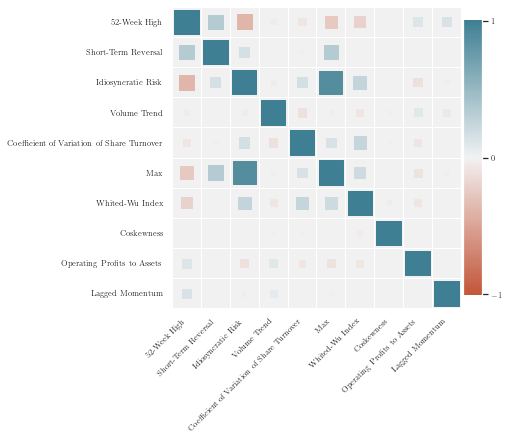

In [30]:
corrplot(corr.iloc[:10,:10], size_scale=600, legend=True)
fig = LatexFigure(plt.gcf())
fig.fit(square=True)

### 10 Most correlated pairs

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


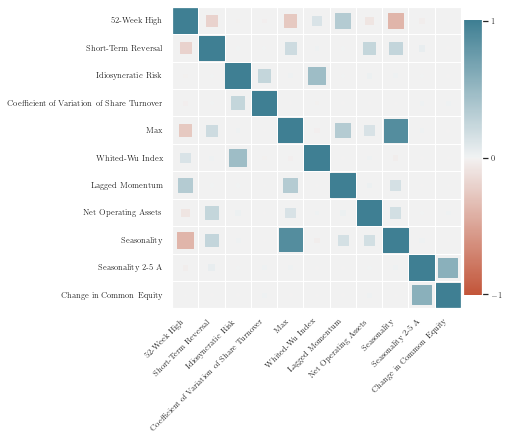

In [31]:
# Get most correlated pairs
so = corr.unstack().abs().sort_values()
hi = so[so!=1].iloc[::2].tail(10).sort_values(ascending=False)
highest = list(set(hi.index.get_level_values(0)).union(set(hi.index.get_level_values(1))))
df = corr.loc[highest,highest]
ordered_index = [s for s in SORTING_LATEX if s in list(df.columns)]
df.columns = ordered_index
df.index = ordered_index
corrplot(df, size_scale=600, legend=True)
fig = LatexFigure(plt.gcf())
fig.fit(square=True)

In [32]:
so = corr.loc[highest,highest].unstack().sort_values()
so[so!=1].iloc[::2].tail(8).sort_values(ascending=False).round(3)

Max                                         Idiosyncratic Risk         0.885
Net Operating Assets                        Change in Common Equity    0.581
Lagged Momentum                             Seasonality                0.474
52-Week High                                Short-Term Reversal        0.348
Short-Term Reversal                         Max                        0.344
Idiosyncratic Risk                          Whited-Wu Index            0.260
Seasonality                                 Seasonality 2-5 A          0.254
Coefficient of Variation of Share Turnover  Whited-Wu Index            0.252
dtype: float64

In [33]:
so[so!=1].iloc[::2].head(2).sort_values(ascending=True).round(3)

52-Week High  Idiosyncratic Risk   -0.385
              Max                  -0.256
dtype: float64

### MR and IG seem to depend on correlation and variance of the feature

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


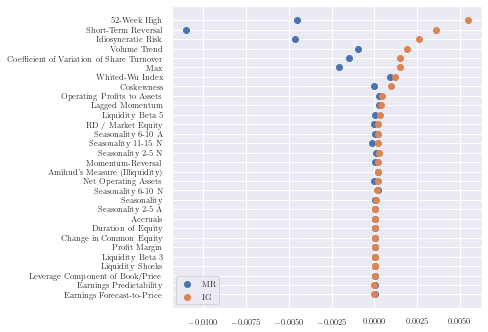

In [34]:
mr16 = subset_models(ar, mr, hidden_layers=None, ytrain=16)-1
ig16 = subset_models(ar, ig, hidden_layers=None, ytrain=16)
means = (pd.DataFrame(mr16.mean(), columns= ["MR"]).rename(index=meta.sc_to_latex))
means["IG"] = ig16.abs().mean().rename(index=meta.sc_to_latex)

fig, axis = plt.subplots(figsize=(8,8))
plt.plot(means, np.arange(len(means)), 'o')
plt.yticks(np.arange(0, len(means.index), 1), means.index.values.tolist())
axis.invert_yaxis()
axis.legend(means.columns.tolist())
fig = LatexFigure(plt.gcf())
fig.fit(square=True)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


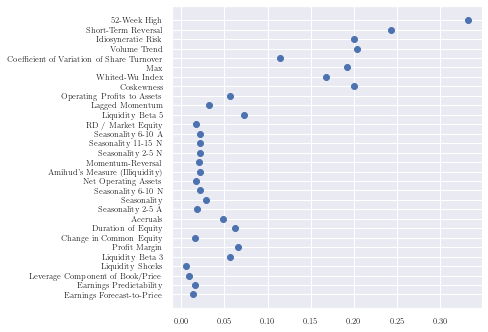

In [50]:
std = dataset.features[SORTING].std()
std.rename(index=meta.sc_to_latex, inplace=True)
std.columns = std.index.values
fig, axis = plt.subplots(figsize=(8,8))
plt.plot(std, np.arange(len(std)), 'o')
plt.yticks(np.arange(0, len(std.index), 1), std.index.values.tolist())
axis.invert_yaxis()
fig = LatexFigure(plt.gcf())
fig.fit(square=True)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


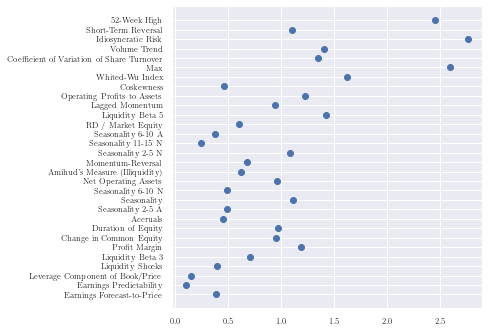

In [35]:
fig, axis = plt.subplots(figsize=(8,8))
plt.plot(corr.abs().sum()-1, np.arange(len(corr)), 'o')
plt.yticks(np.arange(0, len(corr.index), 1), corr.index.values.tolist())
axis.invert_yaxis()
fig = LatexFigure(plt.gcf())
fig.fit(square=True)

# Feature descriptives

### Raw NANs

In [57]:
from data import Filtered
filtered = Filtered()
filtered.load()
nas = filtered.features[SORTING].isna().sum()/filtered.features[SORTING].isna().count()

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


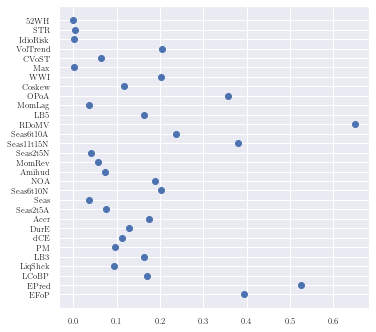

In [66]:
fig, axis = plt.subplots(figsize=(8,8))
plt.plot(nas, np.arange(len(nas)), 'o')
plt.yticks(np.arange(0, len(nas.index), 1), nas.index.values.tolist())
axis.invert_yaxis()
fig = LatexFigure(plt.gcf())
fig.fit(square=True)

### TODO: STD of raw after winsorization but before NAN imputation (to make sure I did not kill some features by normalization) 

### Descriptives of features

In [54]:
df = dataset.features[SORTING].describe().transpose().round(4)
df.rename(index=meta.sc_to_latex, inplace=True)
df = df[df.columns.tolist()[1:]]
#with open('latex/Tables/descr.tex','w') as tf:
#    tf.write(df.to_latex())

In [55]:
df

,mean,std,min,25%,50%,75%,max
52-Week High,-0.0,0.3316,-1.0000,-0.1828,0.0764,0.2445,0.678
Short-Term Reversal,-0.0,0.2430,-0.9831,-0.1276,-0.0178,0.1027,1.000
Idiosyncratic Risk,-0.0,0.1999,-0.2929,-0.1204,-0.0539,0.0528,1.000
Volume Trend,0.0,0.2040,-0.8532,-0.0873,0.0000,0.0979,1.000
Coefficient of Variation of Share Turnover,-0.0,0.1144,-0.1469,-0.0625,-0.0279,0.0170,1.000
Max,0.0,0.1913,-0.2571,-0.1111,-0.0544,0.0416,1.000
Whited-Wu Index,0.0,0.1681,-0.7012,-0.0528,0.0000,0.0489,1.000
Coskewness,-0.0,0.1996,-1.0000,-0.1014,0.0000,0.1074,1.000
Operating Profits to Assets,0.0,0.0562,-0.3581,-0.0122,0.0000,0.0011,1.000
Lagged Momentum,0.0,0.0316,-0.1518,-0.0053,-0.0009,0.0029,1.000


In [38]:
df = meta.signals[~meta.signals.important_otmh_global_liquid.isna()]
df = df[["name_tex", "tex_cite", "class", "class2", "freq", "kelly_sc", "journal"]]
df.set_index('name_tex', inplace=True)
df = df.loc[SORTING_LATEX]

In [39]:
df.head()

,tex_cite,class,class2,freq,kelly_sc,journal
name_tex,,,,,,
52-Week High,george200452,frictions,other,monthly,NaN,JF
Short-Term Reversal,jegadeesh1990evidence,frictions,other,monthly,mom1m,JF
Idiosyncratic Risk,ang2006cross,frictions,other,monthly,idiovol,JF
Volume Trend,haugen1996commonality,frictions,other,monthly,NaN,JFE
Coefficient of Variation of Share Turnover,chordia2001trading,frictions,other,monthly,std_turn,JFE


In [40]:
df.to_latex()

"\\begin{tabular}{lllllll}\n\\toprule\n{} &                    tex\\_cite &      class &         class2 &         freq &  kelly\\_sc & journal \\\\\nname\\_tex                                   &                             &            &                &              &           &         \\\\\n\\midrule\n52-Week High                               &                george200452 &  frictions &          other &      monthly &       NaN &      JF \\\\\nShort-Term Reversal                        &       jegadeesh1990evidence &  frictions &          other &      monthly &    mom1m  &      JF \\\\\nIdiosyncratic Risk                         &                ang2006cross &  frictions &          other &      monthly &   idiovol &      JF \\\\\nVolume Trend                               &       haugen1996commonality &  frictions &          other &      monthly &       NaN &     JFE \\\\\nCoefficient of Variation of Share Turnover &          chordia2001trading &  frictions &          other &    

### Plot of returns

In [82]:
# zscore more than 8 is considered outlier
r_without_outliers = dt.targets.r[np.abs((dt.targets['r'] - dt.targets['r'].mean())/dt.targets['r'].std(ddof=0)<8)]

r_without_outliers.plot.hist(grid=True, bins=100, rwidth=0.9)
plt.xlabel('Monthly Return')
plt.ylabel('Number of Observations')
fig = Figure(plt.gcf())
fig.fit()

NameError: name 'dt' is not defined

### Simulations

In [ ]:
r_crop = dt.targets.r[np.abs((dt.targets['r'] - dt.targets['r'].mean())/dt.targets['r'].std(ddof=0)<8)]
r_simul_crop = r_simul[np.abs((r_simul - r_simul.mean())/r_simul.std(ddof=0)<8)]

r_crop.plot.hist(grid=True, bins=50, rwidth=0.9, range=[-1, 1],alpha=0.5, label="True")
r_simul_crop.plot.hist(grid=True, bins=50, rwidth=0.9, range=[-1, 1],alpha=0.5, label="Simulated")
plt.xlabel('Monthly Return')
plt.ylabel('Number of Observations')
plt.legend(loc='upper right')
fig = LatexFigure(plt.gcf())
fig.fit()

In [ ]:
# Average annualized volatility 
print("vol_true")
vol_true = dt.targets.r.groupby(pd.Grouper(level=0)).apply(lambda group: group.std()*np.sqrt(12)).mean() 
print(vol_true)

print("vol_simul")
vol_simul = r_simul.groupby(pd.Grouper(level=0)).apply(lambda group: group.std()*np.sqrt(12)).mean() 
print(vol_simul)